In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as IPyDisplay
import time
import seaborn as sns; sns.set(); sns.set(style="whitegrid", color_codes=True)

# Visualize the iterations of the training

In [2]:
import torch

from Sequential import Sequential
from activations.ReLu import Relu
from activations.Tanh import Tanh
from activations.Mish import Mish
from helpers.data_generator import generate_data, normalize
from layers.Linear import Linear
from losses.mse import MSE
from optimizers.SGD import SGD
from weight_initialization.xavier_uniform import xavier_uniform

epochs = 100
batch_size = 100

def accuracy(predicted_logits, reference, argmax=True):
    """Compute the ratio of correctly predicted labels"""
    if argmax:
        labels = torch.argmax(predicted_logits, 1)
    else:
        labels = predicted_logits
    correct_predictions = labels.int().eq(reference.int())
    return correct_predictions.sum().float() / correct_predictions.nelement()

# autograd globally off
torch.set_grad_enabled(False)

train_data, train_label = generate_data()
test_data, test_label = generate_data()

mean, std = train_data.mean(), train_data.std()
print("Mean= ", mean, "STD= ",std)

train_data, test_data = normalize(train_data, test_data)
print("--- Dataset ---")
print("Train X: ", train_data.size(), " | Train y: ", train_label.size())
print(" Test X: ",  test_data.size(), " |  Test y: ", test_label.size())

Mean=  tensor(0.4993) STD=  tensor(0.2885)
--- Dataset ---
Train X:  torch.Size([1000, 2])  | Train y:  torch.Size([1000])
 Test X:  torch.Size([1000, 2])  |  Test y:  torch.Size([1000])


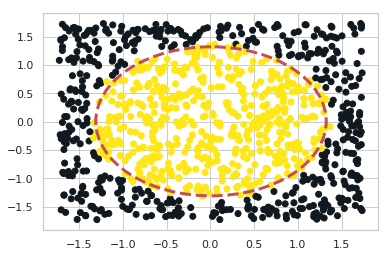

In [3]:
circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")

fig, ax = plt.subplots()
ax.scatter(train_data[:,0].numpy(), train_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(train_label.numpy())])
ax.add_artist(circle1)

---

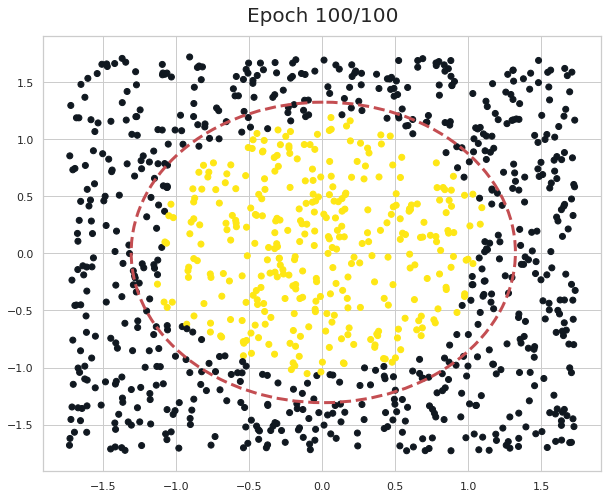

In [4]:
layers =[]
# input layer (2 input units)
linear1 = Linear(2, 25, bias= True, weight_init=xavier_uniform)

# 3 hidden layers (each 25 units)
linear2 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear3 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear4 = Linear(25, 25, bias= True, weight_init=xavier_uniform)

# output layer (2 output units)
linear5 = Linear(25, 2, bias= True, weight_init=xavier_uniform)


layers.append(linear1)
layers.append(Relu())
layers.append(linear2)
layers.append(Relu())
layers.append(linear3)
layers.append(Relu())
layers.append(linear4)
layers.append(Tanh())
layers.append(linear5)

model = Sequential(layers)

criterion = MSE()
optimizer = SGD(model, lr = 0.1)

losses = []
accuracies = []
errors = []
ret_val = ""
verbose = 0 


for epoch in range(1, epochs+1):
    ret_val += "Epoch: " + str(epoch) + "\n"
    for batch_idx in range(0, train_data.size(0), batch_size):
        # axis 0, start from batch_idx until batch_idx+batch_size
        output = model.forward(train_data.narrow(0, batch_idx, batch_size))

        # Calculate loss
        loss = criterion.forward(output, train_label.narrow(0, batch_idx, batch_size))
        losses.append(loss)
        ret_val += "Loss: "+str(loss)+"\n"

        # put to zero weights and bias
        optimizer.zero_grad()

        ##Backpropagation
        # Calculate grad of loss
        loss_grad = criterion.backward()

        # Grad of the model
        model.backward(loss_grad)

        # Update parameters
        optimizer.step()
        
        
     

    test_prediction = model.forward(test_data)
    acc = accuracy(test_prediction, test_label)
    accuracies.append(acc)
    
    errors.append(1-acc)
    ret_val += "Accuracy: "+ str(acc)+"\n"
    
    pred = torch.argmax(test_prediction, 1)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(test_data[:,0].numpy(), test_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.numpy())])
    circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
    ax.add_artist(circle1)
    ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
    IPyDisplay.clear_output(wait=True)
    IPyDisplay.display(plt.gcf())
    plt.close();
    time.sleep(0.1)

if verbose: print(ret_val)
    

# Check if script works as stand-alone

In [1]:
from test import train
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as IPyDisplay
import time
import seaborn as sns; sns.set(); sns.set(style="whitegrid", color_codes=True)

In [2]:
epochs = 100
batch_size = 100
verbose = True
lr = 0.1

In [3]:
train_losses, test_losses, train_accuracies, test_accuracies, train_errors, test_errors = train(epochs, batch_size, lr, verbose)

--- Dataset ---
Train X:  torch.Size([1000, 2])  | Train y:  torch.Size([1000])
 Test X:  torch.Size([1000, 2])  |  Test y:  torch.Size([1000])
Number of model parameters: 204
--- Training ---
Epoch: 1
Train Loss: 1.02e+00
Train Loss: 9.06e-01
Train Loss: 8.50e-01
Train Loss: 7.60e-01
Train Loss: 7.17e-01
Train Loss: 6.67e-01
Train Loss: 6.17e-01
Train Loss: 5.81e-01
Train Loss: 5.94e-01
Train Loss: 5.56e-01
Train Accuracy: 4.86e-01
Test Loss: 5.52e-01
Test Loss: 5.16e-01
Test Loss: 5.48e-01
Test Loss: 5.56e-01
Test Loss: 5.54e-01
Test Loss: 5.37e-01
Test Loss: 5.08e-01
Test Loss: 5.07e-01
Test Loss: 4.44e-01
Test Loss: 5.22e-01
Test Accuracy: 5.23e-01
Epoch: 2
Train Loss: 5.59e-01
Train Loss: 5.31e-01
Train Loss: 5.46e-01
Train Loss: 5.21e-01
Train Loss: 5.41e-01
Train Loss: 5.34e-01
Train Loss: 5.08e-01
Train Loss: 5.45e-01
Train Loss: 5.21e-01
Train Loss: 5.28e-01
Train Accuracy: 4.86e-01
Test Loss: 5.20e-01
Test Loss: 4.87e-01
Test Loss: 5.20e-01
Test Loss: 5.41e-01
Test Loss: 5.36

Train Loss: 1.99e-01
Train Loss: 2.09e-01
Train Loss: 1.90e-01
Train Loss: 2.14e-01
Train Loss: 2.24e-01
Train Loss: 2.50e-01
Train Accuracy: 8.08e-01
Test Loss: 2.59e-01
Test Loss: 2.20e-01
Test Loss: 2.29e-01
Test Loss: 2.23e-01
Test Loss: 1.92e-01
Test Loss: 2.20e-01
Test Loss: 2.01e-01
Test Loss: 2.28e-01
Test Loss: 2.11e-01
Test Loss: 3.12e-01
Test Accuracy: 7.33e-01
Epoch: 23
Train Loss: 2.59e-01
Train Loss: 1.98e-01
Train Loss: 1.85e-01
Train Loss: 2.20e-01
Train Loss: 1.85e-01
Train Loss: 1.98e-01
Train Loss: 1.83e-01
Train Loss: 2.07e-01
Train Loss: 2.23e-01
Train Loss: 2.55e-01
Train Accuracy: 7.66e-01
Test Loss: 2.81e-01
Test Loss: 2.42e-01
Test Loss: 2.55e-01
Test Loss: 2.43e-01
Test Loss: 2.06e-01
Test Loss: 2.28e-01
Test Loss: 2.23e-01
Test Loss: 2.44e-01
Test Loss: 2.40e-01
Test Loss: 3.41e-01
Test Accuracy: 6.95e-01
Epoch: 24
Train Loss: 2.85e-01
Train Loss: 1.98e-01
Train Loss: 1.81e-01
Train Loss: 2.12e-01
Train Loss: 1.78e-01
Train Loss: 1.92e-01
Train Loss: 1.78e-01

Train Loss: 1.51e-01
Train Loss: 1.67e-01
Train Loss: 1.61e-01
Train Loss: 1.73e-01
Train Loss: 1.82e-01
Train Loss: 1.96e-01
Train Accuracy: 8.64e-01
Test Loss: 2.01e-01
Test Loss: 1.85e-01
Test Loss: 1.82e-01
Test Loss: 1.71e-01
Test Loss: 1.48e-01
Test Loss: 1.77e-01
Test Loss: 1.74e-01
Test Loss: 1.97e-01
Test Loss: 1.86e-01
Test Loss: 2.65e-01
Test Accuracy: 7.98e-01
Epoch: 44
Train Loss: 2.30e-01
Train Loss: 1.71e-01
Train Loss: 1.52e-01
Train Loss: 1.75e-01
Train Loss: 1.50e-01
Train Loss: 1.66e-01
Train Loss: 1.61e-01
Train Loss: 1.73e-01
Train Loss: 1.81e-01
Train Loss: 1.96e-01
Train Accuracy: 8.64e-01
Test Loss: 2.01e-01
Test Loss: 1.85e-01
Test Loss: 1.82e-01
Test Loss: 1.70e-01
Test Loss: 1.48e-01
Test Loss: 1.77e-01
Test Loss: 1.74e-01
Test Loss: 1.97e-01
Test Loss: 1.87e-01
Test Loss: 2.65e-01
Test Accuracy: 7.98e-01
Epoch: 45
Train Loss: 2.30e-01
Train Loss: 1.71e-01
Train Loss: 1.52e-01
Train Loss: 1.74e-01
Train Loss: 1.50e-01
Train Loss: 1.66e-01
Train Loss: 1.61e-01

Test Loss: 1.63e-01
Test Loss: 1.43e-01
Test Loss: 1.71e-01
Test Loss: 1.68e-01
Test Loss: 1.92e-01
Test Loss: 1.81e-01
Test Loss: 2.57e-01
Test Accuracy: 8.08e-01
Epoch: 65
Train Loss: 2.21e-01
Train Loss: 1.68e-01
Train Loss: 1.49e-01
Train Loss: 1.69e-01
Train Loss: 1.47e-01
Train Loss: 1.63e-01
Train Loss: 1.58e-01
Train Loss: 1.69e-01
Train Loss: 1.76e-01
Train Loss: 1.89e-01
Train Accuracy: 8.77e-01
Test Loss: 1.91e-01
Test Loss: 1.79e-01
Test Loss: 1.73e-01
Test Loss: 1.62e-01
Test Loss: 1.42e-01
Test Loss: 1.70e-01
Test Loss: 1.67e-01
Test Loss: 1.91e-01
Test Loss: 1.79e-01
Test Loss: 2.55e-01
Test Accuracy: 8.11e-01
Epoch: 66
Train Loss: 2.19e-01
Train Loss: 1.68e-01
Train Loss: 1.48e-01
Train Loss: 1.69e-01
Train Loss: 1.47e-01
Train Loss: 1.63e-01
Train Loss: 1.58e-01
Train Loss: 1.68e-01
Train Loss: 1.76e-01
Train Loss: 1.89e-01
Train Accuracy: 8.79e-01
Test Loss: 1.90e-01
Test Loss: 1.79e-01
Test Loss: 1.72e-01
Test Loss: 1.62e-01
Test Loss: 1.42e-01
Test Loss: 1.70e-01
Te

Train Loss: 1.67e-01
Train Loss: 1.45e-01
Train Loss: 1.61e-01
Train Loss: 1.56e-01
Train Loss: 1.65e-01
Train Loss: 1.72e-01
Train Loss: 1.84e-01
Train Accuracy: 8.85e-01
Test Loss: 1.85e-01
Test Loss: 1.75e-01
Test Loss: 1.67e-01
Test Loss: 1.57e-01
Test Loss: 1.37e-01
Test Loss: 1.66e-01
Test Loss: 1.62e-01
Test Loss: 1.86e-01
Test Loss: 1.72e-01
Test Loss: 2.47e-01
Test Accuracy: 8.29e-01
Epoch: 87
Train Loss: 2.09e-01
Train Loss: 1.64e-01
Train Loss: 1.45e-01
Train Loss: 1.67e-01
Train Loss: 1.45e-01
Train Loss: 1.60e-01
Train Loss: 1.56e-01
Train Loss: 1.65e-01
Train Loss: 1.72e-01
Train Loss: 1.84e-01
Train Accuracy: 8.85e-01
Test Loss: 1.85e-01
Test Loss: 1.75e-01
Test Loss: 1.67e-01
Test Loss: 1.57e-01
Test Loss: 1.37e-01
Test Loss: 1.66e-01
Test Loss: 1.61e-01
Test Loss: 1.86e-01
Test Loss: 1.72e-01
Test Loss: 2.47e-01
Test Accuracy: 8.29e-01
Epoch: 88
Train Loss: 2.09e-01
Train Loss: 1.64e-01
Train Loss: 1.45e-01
Train Loss: 1.67e-01
Train Loss: 1.44e-01
Train Loss: 1.60e-01

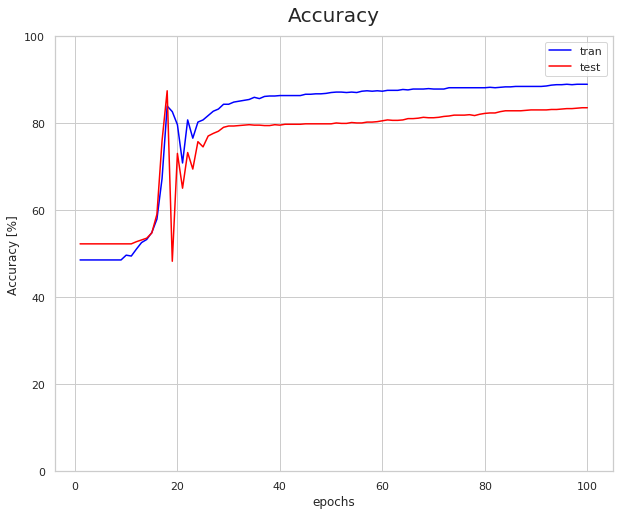

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(train_accuracies)+1), [a.item()*100 for a in train_accuracies], ax=ax, color="blue", label="tran");
sns.lineplot(np.arange(1, len(test_accuracies)+1), [a.item()*100 for a in test_accuracies], ax=ax, color="red", label="test");
ax.set_xlabel("epochs");ax.set_ylabel("Accuracy [%]");ax.set_title("Accuracy", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
ax.legend();

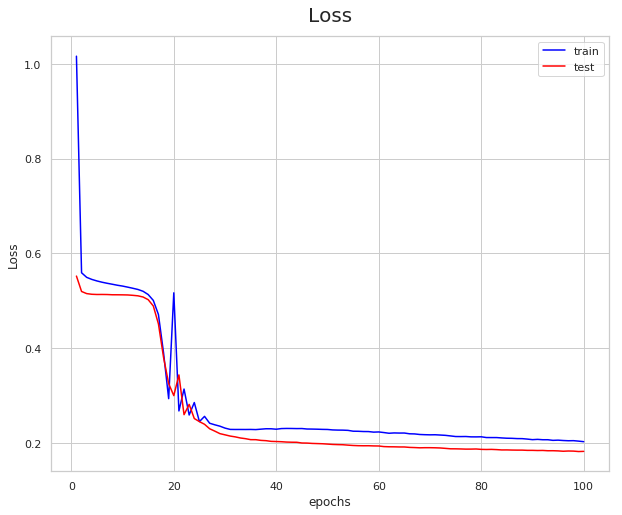

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(train_losses[::1000//batch_size])+1), [a.item() for a in train_losses[::1000//batch_size]], ax=ax, color="blue", label="train");
sns.lineplot(np.arange(1, len(test_losses[::1000//batch_size])+1), [a.item() for a in test_losses[::1000//batch_size]], ax=ax, color="red", label="test");
ax.set_xlabel("epochs");ax.set_ylabel("Loss");ax.set_title("Loss", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.legend();

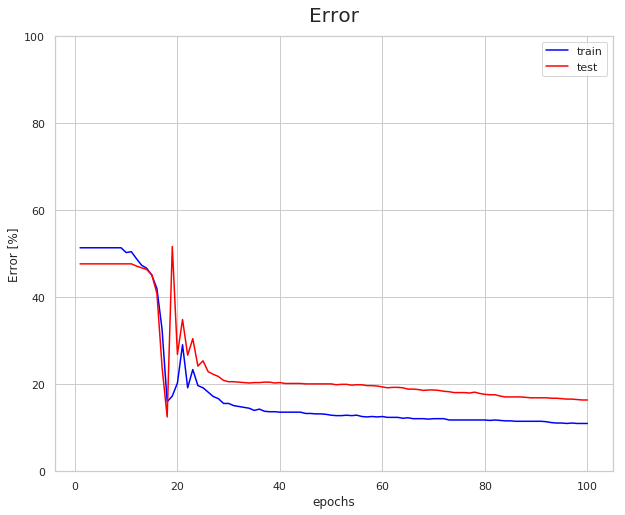

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(train_errors)+1), [a.item()*100 for a in train_errors], ax=ax, color="blue", label="train");
sns.lineplot(np.arange(1, len(test_errors)+1), [a.item()*100 for a in test_errors], ax=ax, color="red", label="test");
ax.set_xlabel("epochs");ax.set_ylabel("Error [%]");ax.set_title("Error", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
ax.legend();

---

# Mish

In [5]:
verbose=0

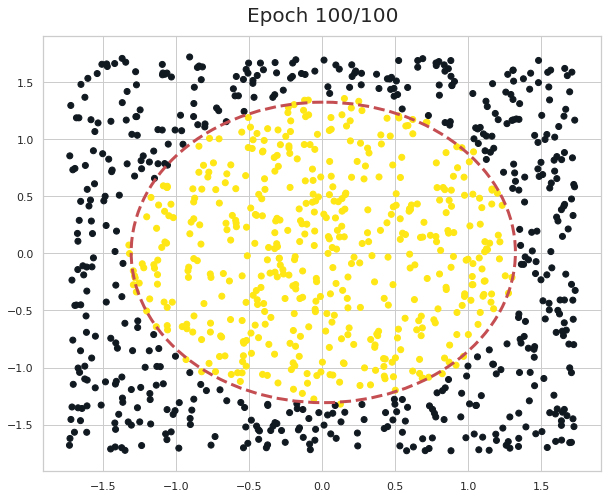

In [6]:
layers =[]
# input layer (2 input units)
linear1 = Linear(2, 25, bias= True, weight_init=xavier_uniform)

# 3 hidden layers (each 25 units)
linear2 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear3 = Linear(25, 25, bias= True, weight_init=xavier_uniform)
linear4 = Linear(25, 25, bias= True, weight_init=xavier_uniform)

# output layer (2 output units)
linear5 = Linear(25, 2, bias= True, weight_init=xavier_uniform)


layers.append(linear1)
layers.append(Mish())
layers.append(linear2)
layers.append(Mish())
layers.append(linear3)
layers.append(Mish())
layers.append(linear4)
layers.append(Tanh())
layers.append(linear5)

model = Sequential(layers)

criterion = MSE()
optimizer = SGD(model, lr = 0.1)

losses2 = []
accuracies2 = []
errors2 = []
ret_val2 = ""

for epoch in range(1, epochs+1):
    ret_val2 += "Epoch: " + str(epoch) + "\n"
    for batch_idx in range(0, train_data.size(0), batch_size):
        # axis 0, start from batch_idx until batch_idx+batch_size
        output = model.forward(train_data.narrow(0, batch_idx, batch_size))

        # Calculate loss
        loss = criterion.forward(output, train_label.narrow(0, batch_idx, batch_size))
        losses2.append(loss)
        ret_val2 += "Loss: "+str(loss)+"\n"

        # put to zero weights and bias
        optimizer.zero_grad()

        ##Backpropagation
        # Calculate grad of loss
        loss_grad = criterion.backward()

        # Grad of the model
        model.backward(loss_grad)

        # Update parameters
        optimizer.step()
        
        
     

    test_prediction = model.forward(test_data)
    acc = accuracy(test_prediction, test_label)
    accuracies2.append(acc)
    
    errors2.append(1-acc)
    ret_val2 += "Accuracy: "+ str(acc)+"\n"
    
    pred = torch.argmax(test_prediction, 1)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(test_data[:,0].numpy(), test_data[:,1].numpy(), c=["#101820FF" if x==0 else "#FEE715FF" for x in np.squeeze(pred.numpy())])
    circle1 = plt.Circle(((0.5-mean.item())/np.power(std,2), (0.5-mean.item())/np.power(std,2)), ((1/np.sqrt(2*np.pi))-mean)/np.power(std,2.07), color='r', fill=False, lw=3, ls="--")
    ax.add_artist(circle1)
    ax.set_title(f"Epoch {epoch}/{epochs}", fontdict={"fontsize":20, "fontweight":1}, pad=15);
    IPyDisplay.clear_output(wait=True)
    IPyDisplay.display(plt.gcf())
    plt.close();
    time.sleep(0.1)
    
if verbose: print(ret_val2)
    

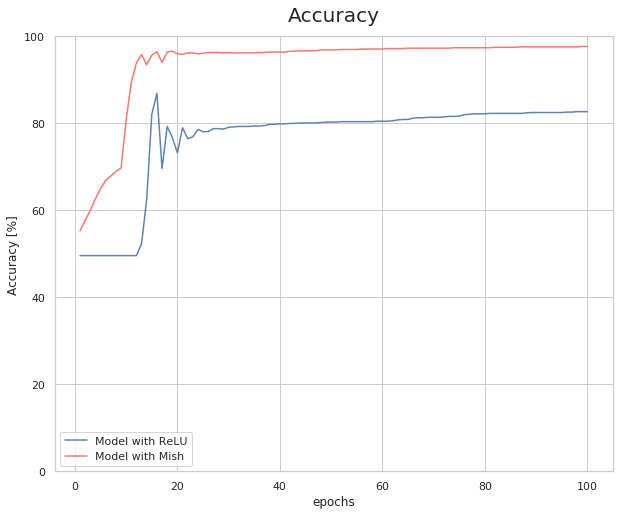

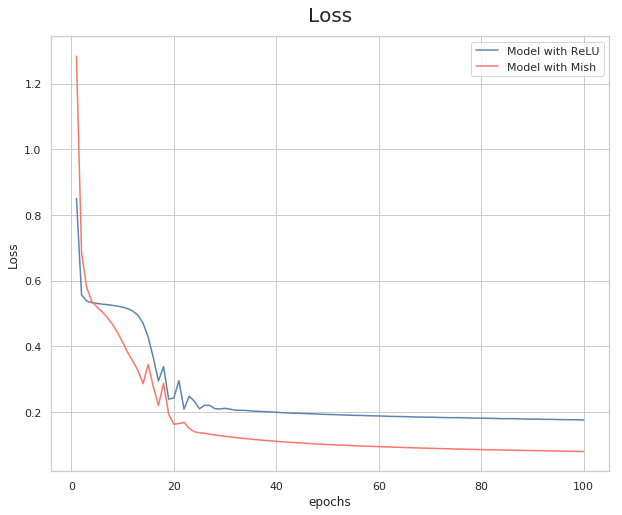

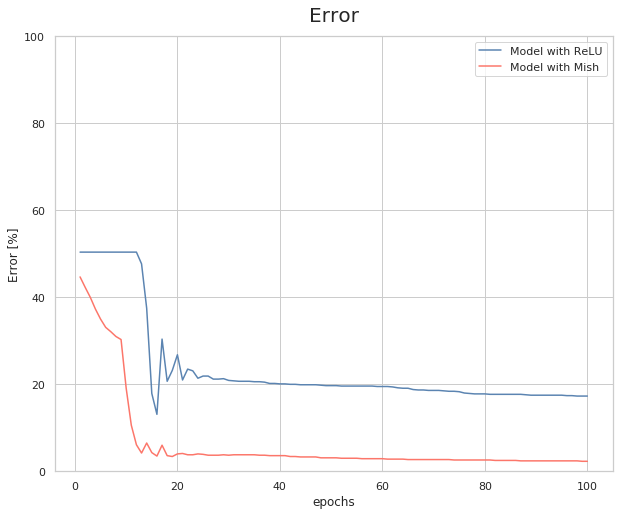

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(accuracies)+1), [a.item()*100 for a in accuracies], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(accuracies2)+1), [a.item()*100 for a in accuracies2], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Accuracy [%]");ax.set_title("Accuracy", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
#ax.legend();

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(losses[::train_data.size(0)//batch_size])+1), [a.item() for a in losses[::train_data.size(0)//batch_size]], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(losses2[::train_data.size(0)//batch_size])+1), [a.item() for a in losses2[::train_data.size(0)//batch_size]], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Loss");ax.set_title("Loss", fontdict={"fontsize":20, "fontweight":1}, pad=15);
#ax.legend();

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(np.arange(1, len(errors)+1), [a.item()*100 for a in errors], ax=ax, color="#5B84B1FF", label="Model with ReLU");
sns.lineplot(np.arange(1, len(errors2)+1), [a.item()*100 for a in errors2], ax=ax, color="#FC766AFF", label="Model with Mish");
#sns.lineplot(x="epoch", y="train_loss", data=df, ax=ax, color="blue", label="train");
ax.set_xlabel("epochs");ax.set_ylabel("Error [%]");ax.set_title("Error", fontdict={"fontsize":20, "fontweight":1}, pad=15);
ax.set_ylim(0,100);
#ax.legend();